In [ ]:
!pip install transformers scikit-learn flask-ngrok

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from typing import Tuple
from transformers import BertTokenizer, BertForSequenceClassification
from torch import nn
import torch
from typing import Tuple
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from typing import List
from flask import Flask, request, jsonify
import torch
from transformers import BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# Bert Model

In [ ]:
# 3. Data Cleaning and Loading Functions
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

In [ ]:
def load_and_clean_data(df):
    df = df[['Score', 'Text']].dropna()
    df = df[df['Score'] != 3]  # remove neutral
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
    df['Text'] = df['Text'].apply(clean_text)
    return df

In [ ]:
def split_data(df):
    return train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [ ]:
# Read the Reviews.csv file
df = pd.read_csv(path + "/Reviews.csv")

In [ ]:
df = load_and_clean_data(df)
df = df.sample(n=3000, random_state=42)

train_texts, val_texts, train_labels, val_labels = split_data(df)

In [ ]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_dict({
    "text": train_texts.tolist(),
    "label": train_labels.tolist()
}).map(tokenize, batched=True).remove_columns("text")

val_dataset = Dataset.from_dict({
    "text": val_texts.tolist(),
    "label": val_labels.tolist()
}).map(tokenize, batched=True).remove_columns("text")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
# Load Model and Define Training Arguments
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./models/bert_amazon",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    fp16=True,  # Enable mixed precision (works on most Colab GPUs)
    report_to="none"
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [ ]:
# Trainer Setup and Training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss
50,0.441000
100,0.261300
150,0.168600
200,0.138300
250,0.117000
300,0.123300


TrainOutput(global_step=300, training_loss=0.20825483004252116, metrics={'train_runtime': 67.9147, 'train_samples_per_second': 70.677, 'train_steps_per_second': 4.417, 'total_flos': 315733266432000.0, 'train_loss': 0.20825483004252116, 'epoch': 2.0})

In [ ]:
print(trainer.evaluate())

{'eval_loss': 0.2000020295381546, 'eval_accuracy': 0.9433333333333334, 'eval_runtime': 3.4207, 'eval_samples_per_second': 175.402, 'eval_steps_per_second': 11.109, 'epoch': 2.0}


In [ ]:
# Save the Model
model.save_pretrained("./bert_sentiment_model")
tokenizer.save_pretrained("./bert_sentiment_model")

('./bert_sentiment_model/tokenizer_config.json',
 './bert_sentiment_model/special_tokens_map.json',
 './bert_sentiment_model/vocab.txt',
 './bert_sentiment_model/added_tokens.json',
 './bert_sentiment_model/tokenizer.json')

In [ ]:
def predict_sentiment(text):
       model.eval()  # Ensure model is in evaluation mode
       inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
       inputs = inputs.to('cuda')  # Move inputs to GPU
       with torch.no_grad():
           outputs = model(**inputs)
           prediction = torch.argmax(outputs.logits, dim=1).item()
       return "positive" if prediction == 1 else "negative"

In [ ]:
# Test It
x = input("Enter A messege: ")
predict_sentiment(x)

Enter A messege: this computer is very good


'positive'

In [ ]:
pip install fastapi uvicorn transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install fastapi uvicorn

In [ ]:
!pip install pyngrok

# DestilGpt2

In [ ]:
from transformers import GPT2PreTrainedModel, GPT2Model

In [ ]:
df = load_and_clean_data(df)
df = df.sample(n=3000, random_state=42)
train_texts, val_texts, train_labels, val_labels = split_data(df)

In [ ]:
# Custom DistilGPT2 Model with Classifier
class GPT2SentimentClassifier(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.gpt2 = GPT2Model(config)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(config.n_embd, 2)  # 2 classes
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state[:, -1, :]  # Use last token's hidden state
        x = self.dropout(last_hidden)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [ ]:
# Initialize
from transformers import GPT2Config
config = GPT2Config.from_pretrained("distilgpt2")
model = GPT2SentimentClassifier(config)
model.gpt2.load_state_dict(
    torch.hub.load_state_dict_from_url('https://huggingface.co/distilgpt2/resolve/main/pytorch_model.bin'),
    strict=False
)
model.eval()

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading: "https://huggingface.co/distilgpt2/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/pytorch_model.bin
100%|██████████| 336M/336M [00:05<00:00, 67.4MB/s]


GPT2SentimentClassifier(
  (gpt2): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)

In [ ]:
# Re-tokenize the same text data for DistilGPT2
from datasets import Dataset as HFDataset
from transformers import AutoTokenizer

gpt2_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # GPT-2 has no pad token


def gpt2_tokenize(batch):
    return gpt2_tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Create HuggingFace Datasets from the same split texts
train_dataset_gpt2 = HFDataset.from_dict({
    "text": train_texts.tolist(),
    "label": train_labels.tolist()
}).map(gpt2_tokenize, batched=True).remove_columns("text")

val_dataset_gpt2 = HFDataset.from_dict({
    "text": val_texts.tolist(),
    "label": val_labels.tolist()
}).map(gpt2_tokenize, batched=True).remove_columns("text")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
# TrainingArguments + Trainer
training_args = TrainingArguments(
    output_dir="./models/distilgpt2_sentiment",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.tensor(logits).argmax(dim=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_gpt2,
    eval_dataset=val_dataset_gpt2,
    compute_metrics=compute_metrics,
)


# Train
trainer.train()

Step,Training Loss
50,0.609300
100,0.538100
150,0.464500
200,0.476000
250,0.386800
300,0.471500
350,0.347800
400,0.342800
450,0.274000
500,0.319600


TrainOutput(global_step=600, training_loss=0.4003323221206665, metrics={'train_runtime': 78.2849, 'train_samples_per_second': 61.315, 'train_steps_per_second': 7.664, 'total_flos': 156783720038400.0, 'train_loss': 0.4003323221206665, 'epoch': 2.0})

In [ ]:
print(trainer.evaluate())

{'eval_loss': 0.3906998336315155, 'eval_accuracy': 0.875, 'eval_runtime': 1.3383, 'eval_samples_per_second': 448.324, 'eval_steps_per_second': 56.041, 'epoch': 2.0}


In [ ]:
# Save
model.save_pretrained("./distilgpt2_sentiment_model")
tokenizer.save_pretrained("./distilgpt2_sentiment_model")

('./distilgpt2_sentiment_model/tokenizer_config.json',
 './distilgpt2_sentiment_model/special_tokens_map.json',
 './distilgpt2_sentiment_model/vocab.txt',
 './distilgpt2_sentiment_model/added_tokens.json',
 './distilgpt2_sentiment_model/tokenizer.json')

In [ ]:
# Predict

def predict_sentiment(text):
    model.eval()
    # Use the gpt2_tokenizer here
    inputs = gpt2_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    # Move inputs to the same device as the model
    inputs = inputs.to(model.device) #add this
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs["logits"], dim=1).item()
    return "positive" if prediction == 1 else "negative"

In [ ]:
# Test It
x = input("Enter A messege: ")
predict_sentiment(x)

Enter A messege: this computer is very good


'positive'

# Logestic Regression

In [ ]:
!pip install -q kagglehub

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Download and read the dataset using kagglehub
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)

# Read the Reviews.csv file
df = pd.read_csv(path + "/Reviews.csv")

Path to dataset files: /kaggle/input/amazon-fine-food-reviews


In [ ]:
#  Drop duplicates and filter rows
df = df.drop_duplicates(subset=["UserId", "ProfileName", "Time", "Text"])
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
df = df.dropna(subset=["Text", "Score"])

# Remove neutral reviews (Score = 3) and assign sentiment labels
df = df[df['Score'] != 3]
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # keep only letters
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['CleanedText'] = df['Text'].apply(clean_text)

In [ ]:
# Split the dataset
X = df['CleanedText']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# Train the Logistic Regression model
Logistic_Model = LogisticRegression()
Logistic_Model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [ ]:
# Evaluate the model
y_pred = Logistic_Model.predict(X_test_tfidf)

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.65      0.73     11519
           1       0.94      0.98      0.96     61314

    accuracy                           0.92     72833
   macro avg       0.89      0.81      0.84     72833
weighted avg       0.92      0.92      0.92     72833


Confusion Matrix:


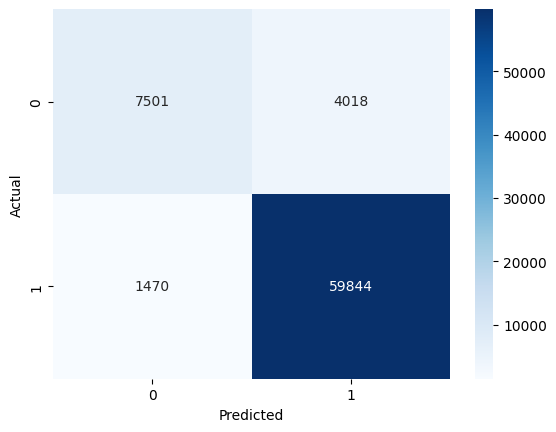

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vect = tfidf.transform([cleaned])
    # Use the Logistic Regression model's predict method
    pred = Logistic_Model.predict(vect)[0]
    return "Positive" if pred == 1 else "Negative"

In [ ]:
# Test it
user_input = input("Enter a review to analyze sentiment: ")
result = predict_sentiment(user_input)
print("Sentiment:", result)

Enter a review to analyze sentiment: this computer is very good
Sentiment: Positive
